In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))

## Load all data:

In [6]:
from utils.format_data import load_json_files_from_folder, aggregate_stories_with_years_before_diagnostic
# import healty aging data
healthy_dir = "../../stories/data_oct_6/healthyAging"
healthy_data = load_json_files_from_folder(healthy_dir)
healthy_agg_data = aggregate_stories_with_years_before_diagnostic(healthy_data)

# import dementia data
dementia_dir = "../../stories/data_oct_6/dementia"
dementia_data = load_json_files_from_folder(dementia_dir)
dementia_agg_data = aggregate_stories_with_years_before_diagnostic(
    dementia_data)

all_data = [healthy_agg_data, dementia_agg_data]

Loaded: mark-edward-thompson.json - Character: Mark Edward Thompson - Start deterioration age: 69
Loaded: olivia-margaret-chen.json - Character: Olivia Margaret Chen - Start deterioration age: 72
Loaded: lisa-carmen-alvarez.json - Character: Lisa Carmen Alvarez - Start deterioration age: 69
Loaded: jessica-marie-holloway.json - Character: Jessica Marie Holloway - Start deterioration age: 75
Loaded: keren-aliza-hadar.json - Character: Keren Aliza Hadar - Start deterioration age: 72
Loaded: jacob-stein.json - Character: Jacob Stein - Start deterioration age: 69
Loaded: robert-elias-garner.json - Character: Robert Elias Garner - Start deterioration age: 72
Loaded: anthony-samuel-reyes.json - Character: Anthony Samuel Reyes - Start deterioration age: 72
Loaded: george-leonard.json - Character: George Leonard - Start deterioration age: 75
Loaded: james-whitaker.json - Character: James Whitaker - Start deterioration age: 72
Loaded: mark-edward-thompson.json - Character: Mark Edward Thompson 

In [7]:
import numpy as np
from scipy import stats
from utils.extract_nlp_features import (
    nouns_freq_in_text,
    word_used_once_frequency,
    word_used_once_or_twice_frequency,
    brunet_index,
    token_type_ratio,
    adposition_frequency,
    uni_and_bi_grams_repetitions,
    word_freq_subtl,
    word_freq_zipf
)

In [8]:
# Load word frequency data
try:
    subtl_and_zipf_df = pd.read_csv('../../subtl_and_zipf.csv')
    subtl_and_zipf_df = subtl_and_zipf_df[[
        'Word', 'FREQcount', 'SUBTLWF', 'Zipf-value']]
    print("Successfully loaded word frequency data.")
except FileNotFoundError:
    print("Warning: subtl_and_zipf.csv not found. Skipping frequency analysis.")
    subtl_and_zipf_df = None

Successfully loaded word frequency data.


In [21]:
def create_comprehensive_multi_group_scatter_plot(data_groups, group_names=None):
    """
    Create a comprehensive 3x3 subplot showing all linguistic metrics as scatter plots
    for multiple groups with different colors and trend lines for each group.

    Parameters:
    -----------
    data_groups : list of lists
        List where each element is a story data list (from aggregate_stories_with_years_before_diagnostic)
    group_names : list of str, optional
        Names for each group (e.g., ['Healthy Aging', 'Dementia'])
        If None, will use 'Group 1', 'Group 2', etc.
    """
    if group_names is None:
        group_names = [f'Group {i+1}' for i in range(len(data_groups))]

    # Prepare the metric functions
    metric_functions = [
        (nouns_freq_in_text, "Noun Token Ratio", "Ratio"),
        (word_used_once_frequency, "Hapax Legomena", "Ratio"),
        (word_used_once_or_twice_frequency, "Low-Frequency (≤2) Ratio", "Ratio"),
        (brunet_index, "Brunet Index", "Index"),
        (token_type_ratio, "Type-Token Ratio", "Ratio"),
        (adposition_frequency, "Adposition Ratio", "Ratio"),
        (uni_and_bi_grams_repetitions, "Repetition Ratio (Uni+Bi)", "Ratio"),
    ]

    # Add frequency metrics if available
    if subtl_and_zipf_df is not None:
        def zipf_metric(text):
            return word_freq_zipf(text, subtl_and_zipf_df)

        def subtl_metric(text):
            return word_freq_subtl(text, subtl_and_zipf_df)

        metric_functions.insert(
            6, (subtl_metric, "SUBTLEX Frequency", "Mean Weighted"))
        metric_functions.insert(
            6, (zipf_metric, "Zipf Frequency", "Mean Weighted"))

    fig, axes = plt.subplots(3, 3, figsize=(16, 12))
    fig.suptitle('Comprehensive Linguistic Analysis: Multi-Group Comparison',
                 fontsize=16, fontweight='bold')

    # Define colors for each group
    group_colors = ["#0f9c9c", "#ff0e0e", '#2ca02c', '#d62728', '#9467bd',
                    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    for i, (metric_function, title, ylabel) in enumerate(metric_functions):
        row = i // 3
        col = i % 3
        ax = axes[row, col]

        # Process each group
        for group_idx, (story_data, group_name) in enumerate(zip(data_groups, group_names)):
            x_values = []
            y_values = []
            # add background color to all subplots
            ax.set_facecolor("#ececec")

            for story_point in story_data:
                try:
                    metric_value = metric_function(story_point['story'])
                    x_values.append(story_point['years_before_diagnostic'])
                    y_values.append(metric_value)
                except Exception:
                    continue

            if x_values:
                # Scatter plot for this group
                ax.scatter(x_values, y_values, alpha=0.5, s=40,
                           color=group_colors[group_idx % len(group_colors)],
                           label=group_name, edgecolors='black', linewidth=0.3)

                # Add trend line for this group
                if len(x_values) > 1:
                    try:
                        z = np.polyfit(x_values, y_values, 1)
                        p = np.poly1d(z)
                        x_trend = np.linspace(
                            min(x_values), max(x_values), 100)
                        ax.plot(x_trend, p(x_trend),
                                color=group_colors[group_idx %
                                                   len(group_colors)],
                                linestyle='-', alpha=0.8, linewidth=1.5)
                    except Exception:
                        pass

        # Calculate overall correlation across all groups combined
        all_x = []
        all_y = []
        for story_data in data_groups:
            for story_point in story_data:
                try:
                    metric_value = metric_function(story_point['story'])
                    all_x.append(story_point['years_before_diagnostic'])
                    all_y.append(metric_value)
                except Exception:
                    continue

        if len(all_x) > 1:
            try:
                r, p_val = stats.pearsonr(all_x, all_y)
                sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                ax.text(0.02, 0.98, f'r={r:.3f} ({sig})\np={p_val:.3g}',
                        transform=ax.transAxes, fontsize=8,
                        verticalalignment='top',
                        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7))
            except Exception:
                pass

        ax.set_xlabel('Years Before Diagnostic', fontsize=9)
        ax.set_ylabel(ylabel, fontsize=9)
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=8)

        if all_x:
            ax.set_xticks(np.arange(-15, max(all_x)+1, 3))
            ax.set_xlim(left=-16)

        if not all_x:
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center',
                    transform=ax.transAxes, fontsize=12,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

    # Add legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5),
                   title='Groups', title_fontsize=10, fontsize=8)

    plt.tight_layout(rect=[0, 0.03, 0.85, 0.95])
    plt.show()

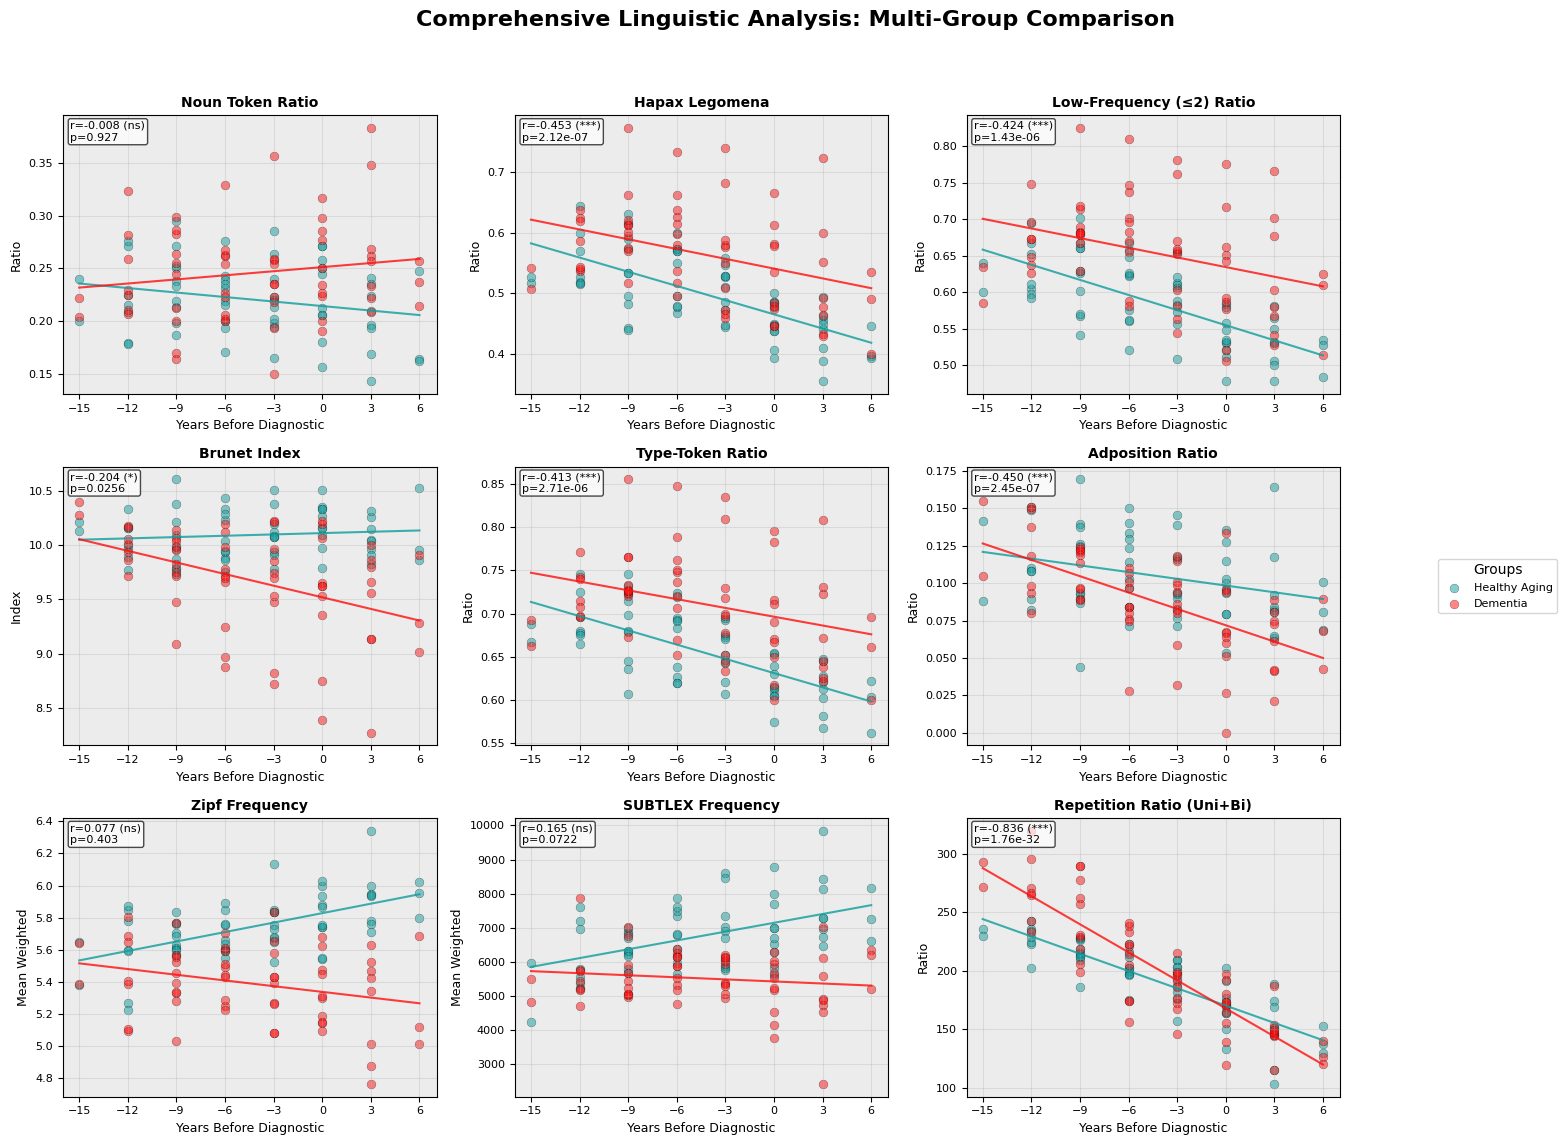

In [22]:
# Create comprehensive multi-group scatter plot
create_comprehensive_multi_group_scatter_plot(
    all_data,
    group_names=['Healthy Aging', 'Dementia']
)